In [51]:
import yfinance as yf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone

In [52]:
df_apple_to_csv = yf.download("AAPL", start="2020-01-01", end="2025-08-13")
df_microsoft_to_csv = yf.download("MSFT", start="2020-01-01", end="2025-08-13")
df_amazon_to_csv = yf.download("AMZN", start="2020-01-01", end="2025-08-13")


apple_path = 'datasets/apple.csv'
microsoft_path = 'datasets/microsoft.csv'
amazon_path = 'datasets/amazon.csv'

df_apple_to_csv.to_csv(apple_path)
df_microsoft_to_csv.to_csv(microsoft_path)
df_amazon_to_csv.to_csv(amazon_path)

df_apple = pd.read_csv(apple_path)
df_microsoft = pd.read_csv(microsoft_path)
df_amazon = pd.read_csv(amazon_path)

C:\Users\acer\AppData\Local\Temp\ipykernel_16300\1102566560.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_apple_to_csv = yf.download("AAPL", start="2020-01-01", end="2025-08-13")
[*********************100%***********************]  1 of 1 completed
C:\Users\acer\AppData\Local\Temp\ipykernel_16300\1102566560.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_microsoft_to_csv = yf.download("MSFT", start="2020-01-01", end="2025-08-13")
[*********************100%***********************]  1 of 1 completed
C:\Users\acer\AppData\Local\Temp\ipykernel_16300\1102566560.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_amazon_to_csv = yf.download("AMZN", start="2020-01-01", end="2025-08-13")
[*********************100%***********************]  1 of 1 completed


In [53]:
df_apple.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
1,Date,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,72.53852081298828,72.59889913772518,71.29231130597061,71.5458973217052,135480400
3,2020-01-03,71.83329010009766,72.59405542623057,71.60868452797844,71.76566667933918,146322800
4,2020-01-06,72.40567016601562,72.4443131708714,70.70300468370534,70.95418053006813,118387200


In [54]:
df_microsoft.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
1,Date,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,153.04226684570312,153.14707784853206,150.8603108363314,151.28907783375524,22622100
3,2020-01-03,151.1366729736328,152.4039284141965,150.6030947963249,150.8508379064428,21116200
4,2020-01-06,151.52731323242188,151.59401776506908,149.12619721864283,149.6693128510685,20813700


In [55]:
df_amazon.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
1,Date,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,94.90049743652344,94.90049743652344,93.2074966430664,93.75,80580000
3,2020-01-03,93.74849700927734,94.30999755859375,93.2249984741211,93.2249984741211,75288000
4,2020-01-06,95.14399719238281,95.18450164794922,93.0,93.0,81236000


In [56]:
df_apple['Date'] = df_apple['Price']
df_apple = df_apple.drop(index=[0,1], columns='Price')

df_microsoft['Date'] = df_microsoft['Price']
df_microsoft = df_microsoft.drop(index=[0,1], columns='Price')

df_amazon['Date'] = df_amazon['Price']
df_amazon = df_amazon.drop(index=[0,1], columns='Price')

In [57]:
df_apple.head()

,Close,High,Low,Open,Volume,Date
2,72.53852081298828,72.59889913772518,71.29231130597061,71.5458973217052,135480400,2020-01-02
3,71.83329010009766,72.59405542623057,71.60868452797844,71.76566667933918,146322800,2020-01-03
4,72.40567016601562,72.4443131708714,70.70300468370534,70.95418053006813,118387200,2020-01-06
5,72.06515502929688,72.67134838279743,71.84537704823941,72.41534488187352,108872000,2020-01-07
6,73.22442626953125,73.52631792855652,71.76810120120939,71.76810120120939,132079200,2020-01-08


In [58]:
df_microsoft.head()

,Close,High,Low,Open,Volume,Date
2,153.04226684570312,153.14707784853206,150.8603108363314,151.28907783375524,22622100,2020-01-02
3,151.1366729736328,152.4039284141965,150.6030947963249,150.8508379064428,21116200,2020-01-03
4,151.52731323242188,151.59401776506908,149.12619721864283,149.6693128510685,20813700,2020-01-06
5,150.14569091796875,152.13708538758584,149.89796243459426,151.8036064144559,21634100,2020-01-07
6,152.53732299804688,153.21383324803998,150.498283797712,151.43204560824276,27746500,2020-01-08


In [59]:
df_amazon.head()

,Close,High,Low,Open,Volume,Date
2,94.90049743652344,94.90049743652344,93.2074966430664,93.75,80580000,2020-01-02
3,93.74849700927734,94.30999755859375,93.2249984741211,93.2249984741211,75288000,2020-01-03
4,95.14399719238281,95.18450164794922,93.0,93.0,81236000,2020-01-06
5,95.34300231933594,95.69450378417969,94.60199737548828,95.2249984741211,80898000,2020-01-07
6,94.59850311279297,95.55000305175781,94.3219985961914,94.9020004272461,70160000,2020-01-08


In [60]:
df_apple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1410 entries, 2 to 1411
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Close   1410 non-null   object
 1   High    1410 non-null   object
 2   Low     1410 non-null   object
 3   Open    1410 non-null   object
 4   Volume  1410 non-null   object
 5   Date    1410 non-null   object
dtypes: object(6)
memory usage: 66.2+ KB


In [61]:
df_apple.describe()

,Close,High,Low,Open,Volume,Date
count,1410,1410,1410,1410,1410,1410
unique,1394,1410,1410,1410,1408,1410
top,139.26513671875,230.8000030517578,227.07000732421875,228.00999450683594,90956700,2025-08-12
freq,2,1,1,1,2,1


In [62]:
df_apple.isna().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
Date      0
dtype: int64

C:\Users\acer\AppData\Local\Temp\ipykernel_16300\1511821517.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year


        Close       High        Low       Open       Volume       Date  \
15  76.728767  77.281827  76.634574  76.941293  101832400.0 2020-01-22   
16  77.098289  77.177986  76.233668  76.781908  104472000.0 2020-01-23   
17  76.876099  78.088493  76.685301  77.344635  146537600.0 2020-01-24   
18  74.615509  75.296571  73.632549  74.883585  161940000.0 2020-01-27   
19  76.726349  76.897821  75.398026  75.497047  162234000.0 2020-01-28   

    Price Change      Gain      Loss  Average Gain  Average Loss        RS  \
15      0.272896  0.272896  0.000000      0.508211      0.208908  2.432707   
16      0.369522  0.369522  0.000000      0.534605      0.208908  2.559052   
17     -0.222191  0.000000  0.222191      0.534605      0.174405  3.065315   
18     -2.260590  0.000000  2.260590      0.493721      0.335875  1.469953   
19      2.110840  2.110840  0.000000      0.644495      0.311553  2.068655   

          RSI  Short EMA   Long EMA      MACD  Signal Line  MACD Histogram  \
15  70.8

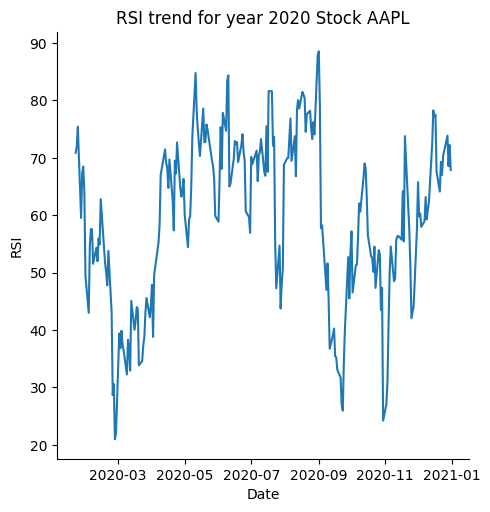

<Figure size 2000x1000 with 0 Axes>

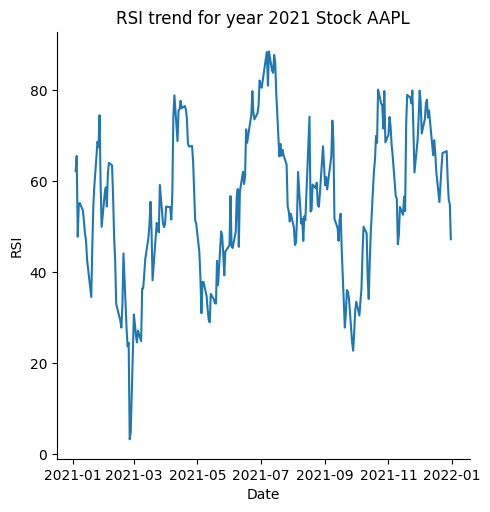

<Figure size 2000x1000 with 0 Axes>

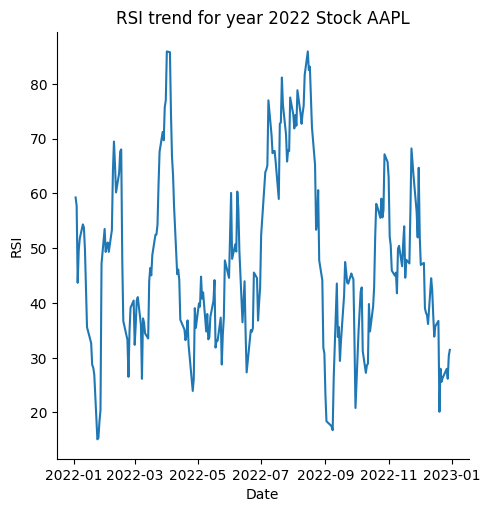

<Figure size 2000x1000 with 0 Axes>

C:\Users\acer\AppData\Local\Temp\ipykernel_16300\1511821517.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year


        Close       High        Low       Open      Volume       Date  \
15  94.373001  95.125000  94.167000  94.804497  64326000.0 2020-01-22   
16  94.228996  94.499001  93.638000  94.255501  49692000.0 2020-01-23   
17  93.082001  94.749496  92.372002  94.568497  75324000.0 2020-01-24   
18  91.417000  92.050003  90.766998  91.000000  70570000.0 2020-01-27   
19  92.662498  92.905502  91.500999  92.025002  56160000.0 2020-01-28   

    Price Change      Gain      Loss  Average Gain  Average Loss        RS  \
15     -0.226997  0.000000  0.226997      0.329679      0.367358  0.897434   
16     -0.144005  0.000000  0.144005      0.329679      0.377644  0.872990   
17     -1.146996  0.000000  1.146996      0.329679      0.377286  0.873818   
18     -1.665001  0.000000  1.665001      0.230001      0.496215  0.463510   
19      1.245499  1.245499  0.000000      0.304750      0.496215  0.614150   

          RSI  Short EMA   Long EMA      MACD  Signal Line  MACD Histogram  \
15  47.297251 

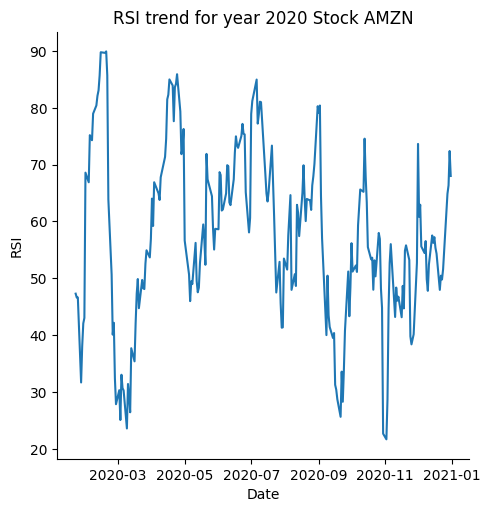

<Figure size 2000x1000 with 0 Axes>

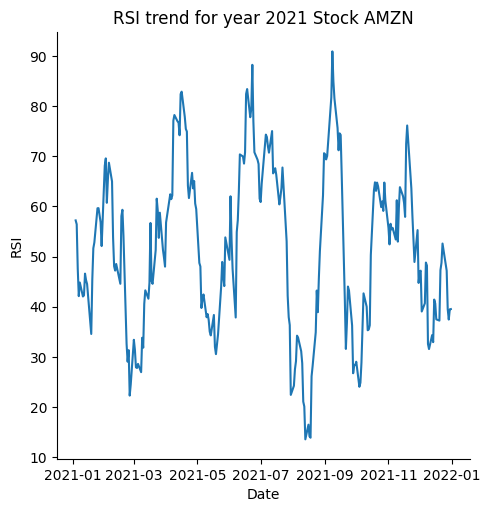

<Figure size 2000x1000 with 0 Axes>

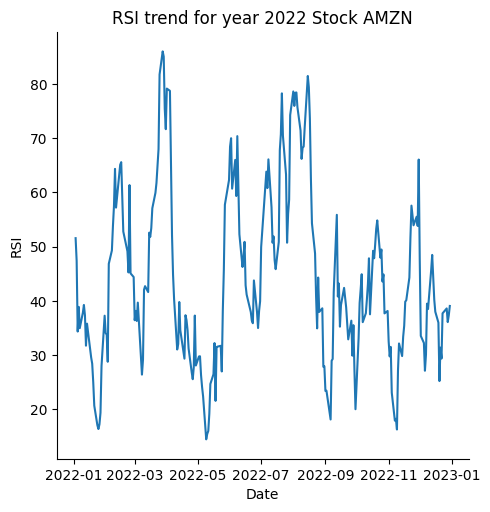

<Figure size 2000x1000 with 0 Axes>

C:\Users\acer\AppData\Local\Temp\ipykernel_16300\1511821517.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year


         Close        High         Low        Open      Volume       Date  \
15  157.882614  159.588174  157.863554  159.502409  24138800.0 2020-01-22   
16  158.854523  158.930750  157.472933  158.349528  19680800.0 2020-01-23   
17  157.253754  159.626286  156.691592  159.607225  24918100.0 2020-01-24   
18  154.623993  155.672103  152.642121  153.547299  32078100.0 2020-01-27   
19  157.654022  157.939857  155.376777  156.053273  24899900.0 2020-01-28   

    Price Change      Gain      Loss  Average Gain  Average Loss        RS  \
15     -0.762253  0.000000  0.762253      0.805135      0.459396  1.752594   
16      0.971909  0.971909  0.000000      0.874557      0.459396  1.903710   
17     -1.600769  0.000000  1.600769      0.874557      0.437623  1.998426   
18     -2.629761  0.000000  2.629761      0.846655      0.625463  1.353644   
19      3.030029  3.030029  0.000000      1.063085      0.526776  2.018098   

          RSI   Short EMA    Long EMA      MACD  Signal Line  MACD H

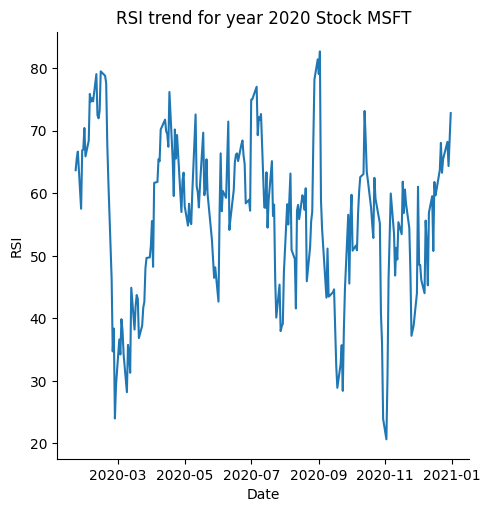

<Figure size 2000x1000 with 0 Axes>

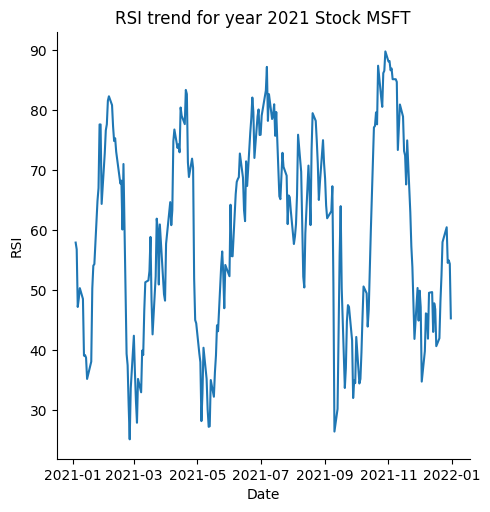

<Figure size 2000x1000 with 0 Axes>

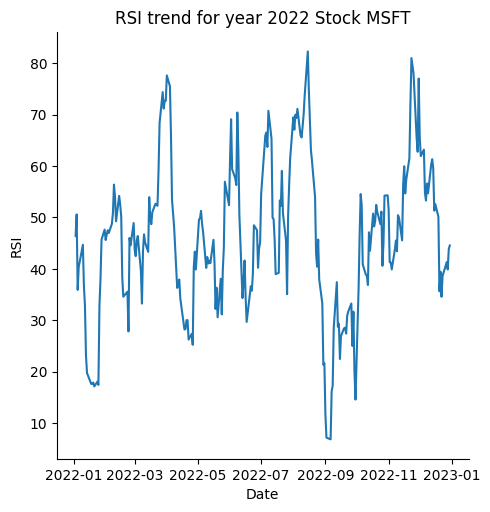

<Figure size 2000x1000 with 0 Axes>

In [67]:
dfs = [df_apple, df_amazon, df_microsoft]
window = 14
short_period = 12
long_period = 26
signal_line_period = 9
years = list(range(2020,2026))
stocks = ['AAPL', 'AMZN', 'MSFT']
counter = 0
for df in dfs:
    df['Close'] = df['Close'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Open'] = df['Open'].astype(float)
    df['Volume'] = df['Volume'].astype(float)
    df['Date'] = pd.to_datetime(df['Date'])

    df['Price Change'] = df['Close'].diff().fillna(0)

    df['Gain'] = df.loc[df['Price Change'] > 0, 'Price Change']
    df['Loss'] = -df.loc[df['Price Change'] < 0, 'Price Change']

    df['Gain'] = df['Gain'].fillna(0)
    df['Loss'] = df['Loss'].fillna(0)

    df['Average Gain'] = df['Gain'].rolling(window=window).mean().fillna(0)
    df['Average Loss'] = df['Loss'].rolling(window=window).mean().fillna(0)

    #df = df.drop(index=list(range(2,15)))

    df['RS'] = df['Average Gain'] / df['Average Loss']

    df['RSI'] = 100 - (100 / (1 + df['RS']))

    df['Short EMA'] = df['Close'].ewm(span=short_period,adjust=False).mean()
    df['Long EMA'] = df['Close'].ewm(span=long_period, adjust=False).mean()

    df['MACD'] = df['Short EMA'] - df['Long EMA']

    df['Signal Line'] = df['MACD'].ewm(span=signal_line_period, adjust=False).mean()
    
    df['MACD Histogram'] = df['MACD'] - df['Signal Line']
    
    df = df.dropna()
    
    df['Year'] = df['Date'].dt.year
    
    print(df.head())
    
    for i in range(len(stocks)):
        sns.relplot(data=df.loc[df['Year'] == years[i]], x='Date', y='RSI', kind='line')
        plt.title(f'RSI trend for year {years[i]} Stock {stocks[counter]}')
        plt.figure(figsize=(20,10))
        plt.show()
        
    counter += 1


In [ ]:

# df_apple['Close'] = df_apple['Close'].astype(float)
# df_apple['High'] = df_apple['High'].astype(float)
# df_apple['Low'] = df_apple['Low'].astype(float)
# df_apple['Open'] = df_apple['Open'].astype(float)
# df_apple['Volume'] = df_apple['Volume'].astype(float)
# df_apple['Date'] = pd.to_datetime(df_apple['Date'])

In [ ]:
# df_apple.describe()

In [ ]:
# df_apple[df_apple['Close'] < 0].head()

In [ ]:
# #AAPL FEATURE ENGINEERING

# #CALCULATING RSI VALUE FOR TO CHECK MOMENTUM
# window = 14

# df_apple['Price Change'] = df_apple['Close'].diff().fillna(0)

# df_apple['Gain'] = df_apple.loc[df_apple['Price Change'] > 0, 'Price Change']
# df_apple['Loss'] = -df_apple.loc[df_apple['Price Change'] < 0, 'Price Change']

# df_apple['Gain'] = df_apple['Gain'].fillna(0)
# df_apple['Loss'] = df_apple['Loss'].fillna(0)

# df_apple['Average Gain'] = df_apple['Gain'].rolling(window=window).mean().fillna(0)
# df_apple['Average Loss'] = df_apple['Loss'].rolling(window=window).mean().fillna(0)

# #df_apple = df_apple.drop(index=list(range(2,15)))

# df_apple['RS'] = df_apple['Average Gain'] / df_apple['Average Loss']

# df_apple['RSI'] = 100 - (100 / (1 + df_apple['RS']))

# # df_apple['Target Close'] = df_apple['Close'].shift(-1) 

# df_apple.head()
# # df_apple['Average Gain']
# # df_apple['Average Loss']
# # df_apple['RS']
# # df_apple['RSI']

In [ ]:
# df_apple = df_apple.drop(columns=['Gain', 'Loss'])

In [ ]:
#FEATURE ENGINEERING

#CALCULATING MACD VALUE FOR VOLATILITY
# short_period = 12
# long_period = 26
# signal_line_period = 9

# # df_apple['Short EMA'] = (df_apple['Close'] * (2 / (short_period + 1))) + ( (1 - (2 / (short_period + 1))) * df_apple['Close'].shift(1))
# # df_apple['Long EMA'] = (df_apple['Close'] * (2 / (long_period + 1))) + ( (1 - (2 / (long_period + 1))) * df_apple['Close'].shift(1))

# df_apple['Short EMA'] = df_apple['Close'].ewm(span=short_period,adjust=False).mean()
# df_apple['Long EMA'] = df_apple['Close'].ewm(span=long_period, adjust=False).mean()

# df_apple['MACD'] = df_apple['Short EMA'] - df_apple['Long EMA']

# # df_apple['Signal Line'] = (df_apple['MACD'] * (2 / (signal_line_period + 1))) + ( (1 - (2 / (signal_line_period + 1))) * df_apple['MACD'].shift(1))
# df_apple['Signal Line'] = df_apple['MACD'].ewm(span=signal_line_period, adjust=False).mean()

# df_apple['MACD Histogram'] = df_apple['MACD'] - df_apple['Signal Line']


In [ ]:
# df_apple.head(n=27)     

In [ ]:
# print(df_apple.shape)
# df_apple.info()

In [ ]:
# df_apple = df_apple.dropna()

In [ ]:
# df_apple.head()

In [ ]:
# sns.relplot(data=df_apple.loc[(df_apple['Date'].dt.year >= 2023) & (df_apple['Date'].dt.year < 2025), :], x='Date', y='RSI', kind='line')
# plt.show()

# df_apple['Year'] = df_apple['Date'].dt.year

# years = list(range(2020,2026))

# for year in years:
#     sns.relplot(data=df_apple.loc[df_apple['Year'] == year], x='Date', y='RSI', kind='line')
#     plt.title(f'RSI trend for year {year}')
#     plt.figure(figsize=(20,10))
#     plt.show()

In [ ]:
#MACD	Signal Line	MACD Histogram
for year in years:
    sns.relplot(data=df_apple.loc[df_apple['Year'] == year], x='Date', y='MACD', kind='line')
    plt.title(f'MACD trend for year {year}')
    plt.figure(figsize=(20,10))
    plt.show()

KeyError: 'Year'

In [ ]:
df_apple.head()

,Close,High,Low,Open,Volume,Date,Price Change,Average Gain,Average Loss,RS,RSI,Short EMA,Long EMA,MACD,Signal Line,MACD Histogram,Year
15,76.728775,77.281835,76.634581,76.941301,101832400.0,2020-01-22,0.272903,0.508215,0.208911,2.432684,70.868274,75.349474,74.270929,1.078545,0.738868,0.339677,2020
16,77.098282,77.177978,76.233660,76.781900,104472000.0,2020-01-23,0.369507,0.534609,0.208911,2.559021,71.902387,75.618521,74.480362,1.138159,0.818727,0.319432,2020
17,76.876099,78.088493,76.685301,77.344635,146537600.0,2020-01-24,-0.222183,0.534609,0.174408,3.065276,75.401425,75.811995,74.657824,1.154170,0.885815,0.268355,2020
18,74.615501,75.296563,73.632541,74.883578,161940000.0,2020-01-27,-2.260597,0.493725,0.335879,1.469948,59.513312,75.627919,74.654689,0.973230,0.903298,0.069931,2020
19,76.726341,76.897814,75.398018,75.497040,162234000.0,2020-01-28,2.110840,0.644499,0.311555,2.068656,67.412444,75.796907,74.808145,0.988762,0.920391,0.068371,2020


In [ ]:
X = df_apple.drop(columns=['Date', 'Close'])
y = df_apple['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
    ])

In [ ]:
kfold = KFold(n_splits=6, random_state=30, shuffle=True)

cv = GridSearchCV(estimator=model,param_grid={
    'lr__n_jobs': [10,20,50],
    'scaler__with_mean':[True, False]
    },cv=kfold)

cv.fit(X_train, y_train)

print("Best parameter:", cv.best_params_)
print("Best score:", cv.best_score_)


Best parameter: {'lr__n_jobs': 10, 'scaler__with_mean': True}
Best score: 0.9996759727109293


In [ ]:
y_pred = cv.predict(X_test)

print("Predicted values respectively:",y_pred[0:10])

print("Correct values:")
print(y_test[0:10])

Predicted values respectively: [133.85923926 226.10599385 229.25878485 190.12901712 173.25180842
 151.84382533 141.87651144 213.65598709 206.6958512  192.09895838]
Correct values:
378     133.879700
1280    227.203445
1234    229.056870
994     191.558212
493     172.296021
687     151.331161
708     141.161713
1407    213.008255
1354    206.625504
1003    191.974670
Name: Close, dtype: float64
